<ipython-input-1-4948bac480d3>:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  customer_data = customer_data.fillna(0)


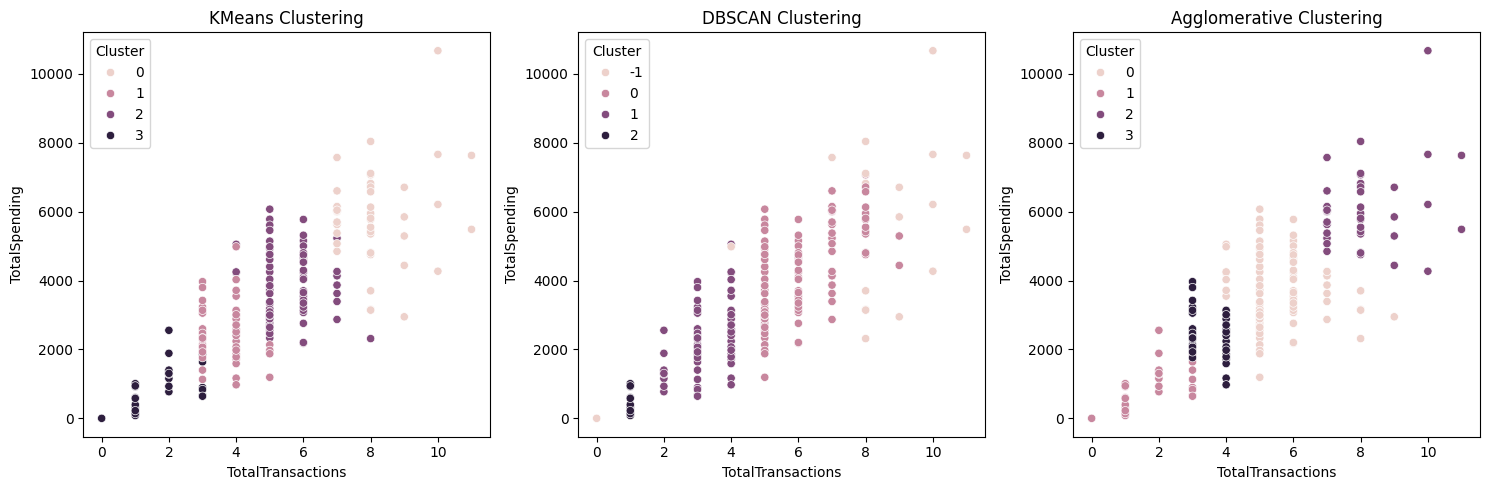

KMeans:
  Silhouette Score: 0.396
  Davies-Bouldin Index: 0.800
--------------------
DBSCAN:
  Silhouette Score: 0.324
  Davies-Bouldin Index: 1.217
--------------------
Agglomerative:
  Silhouette Score: 0.377
  Davies-Bouldin Index: 0.788
--------------------
Best Algorithm (based on DB Index): Agglomerative


In [1]:
#TASK 3
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")
products_df = pd.read_csv("Products.csv")

# Merge transactions with product information
merged_df = transactions_df.merge(products_df, on='ProductID', how='left')

# Feature Engineering
customer_data = customers_df.merge(merged_df.groupby('CustomerID').agg(
    {'TransactionID': 'count', 'TotalValue': 'sum', 'ProductID': 'nunique'}  # Number of unique products purchased
).rename(columns={'TransactionID': 'TotalTransactions', 'TotalValue': 'TotalSpending', 'ProductID': 'UniqueProducts'}),
    on='CustomerID', how='left')

# Calculate recency (last purchase date)
customer_data['LastPurchaseDate'] = pd.to_datetime(merged_df.groupby('CustomerID')['TransactionDate'].max())
customer_data['Recency'] = (pd.to_datetime('today') - customer_data['LastPurchaseDate']).dt.days

# Handle missing values (if any)
customer_data = customer_data.fillna(0)

# Select features for clustering
features = ['TotalTransactions', 'TotalSpending', 'UniqueProducts', 'Recency']

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[features])

# Define clustering algorithms
algorithms = {
    'KMeans': KMeans(n_clusters=4, random_state=42),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'Agglomerative': AgglomerativeClustering(n_clusters=4)
}

# Evaluate each algorithm and store results
results = {}
for name, algorithm in algorithms.items():
    labels = algorithm.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, labels)
    db_index = davies_bouldin_score(scaled_features, labels)
    results[name] = {'labels': labels, 'silhouette': silhouette_avg, 'db_index': db_index}

# Visualize clusters (using 2D scatter plots for simplicity)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
customer_data['Cluster'] = results['KMeans']['labels']
sns.scatterplot(x='TotalTransactions', y='TotalSpending', hue='Cluster', data=customer_data)
plt.title('KMeans Clustering')

plt.subplot(1, 3, 2)
customer_data['Cluster'] = results['DBSCAN']['labels']
sns.scatterplot(x='TotalTransactions', y='TotalSpending', hue='Cluster', data=customer_data)
plt.title('DBSCAN Clustering')

plt.subplot(1, 3, 3)
customer_data['Cluster'] = results['Agglomerative']['labels']
sns.scatterplot(x='TotalTransactions', y='TotalSpending', hue='Cluster', data=customer_data)
plt.title('Agglomerative Clustering')

plt.tight_layout()
plt.show()

# Print results
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  Silhouette Score: {metrics['silhouette']:.3f}")
    print(f"  Davies-Bouldin Index: {metrics['db_index']:.3f}")
    print("-" * 20)

# Choose the algorithm with the best DB Index
best_algorithm = min(results, key=lambda x: results[x]['db_index'])
print(f"Best Algorithm (based on DB Index): {best_algorithm}")

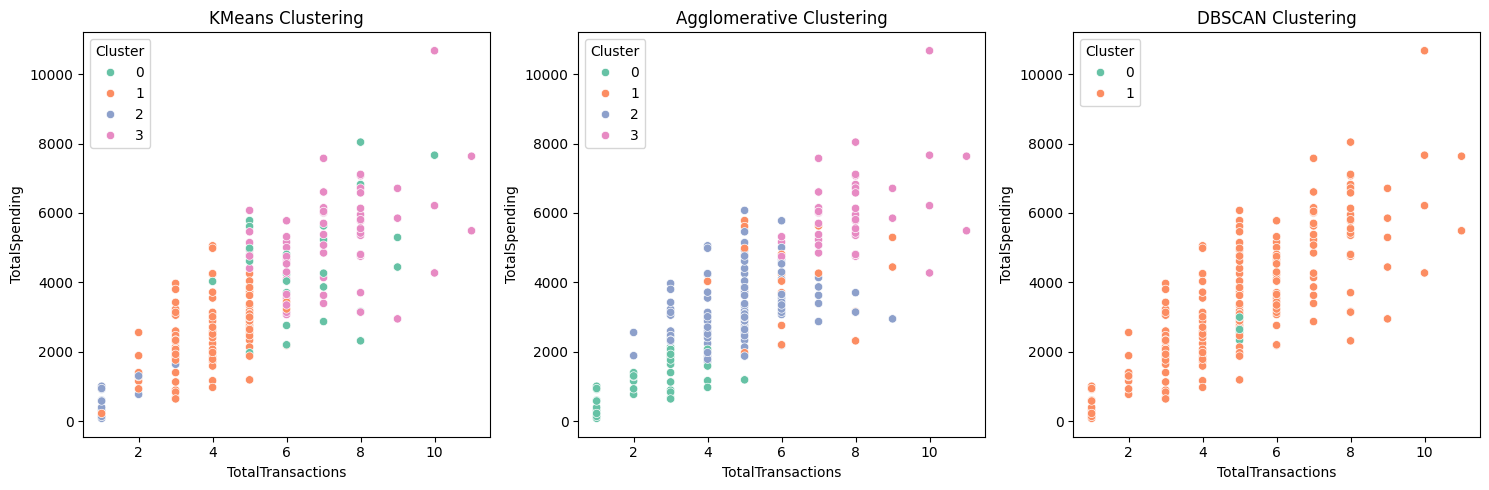

KMeans:
  Silhouette Score: 0.264
  Davies-Bouldin Index: 1.213
--------------------
Agglomerative:
  Silhouette Score: 0.213
  Davies-Bouldin Index: 1.348
--------------------
DBSCAN:
  Silhouette Score: -0.213
  Davies-Bouldin Index: 2.174
--------------------


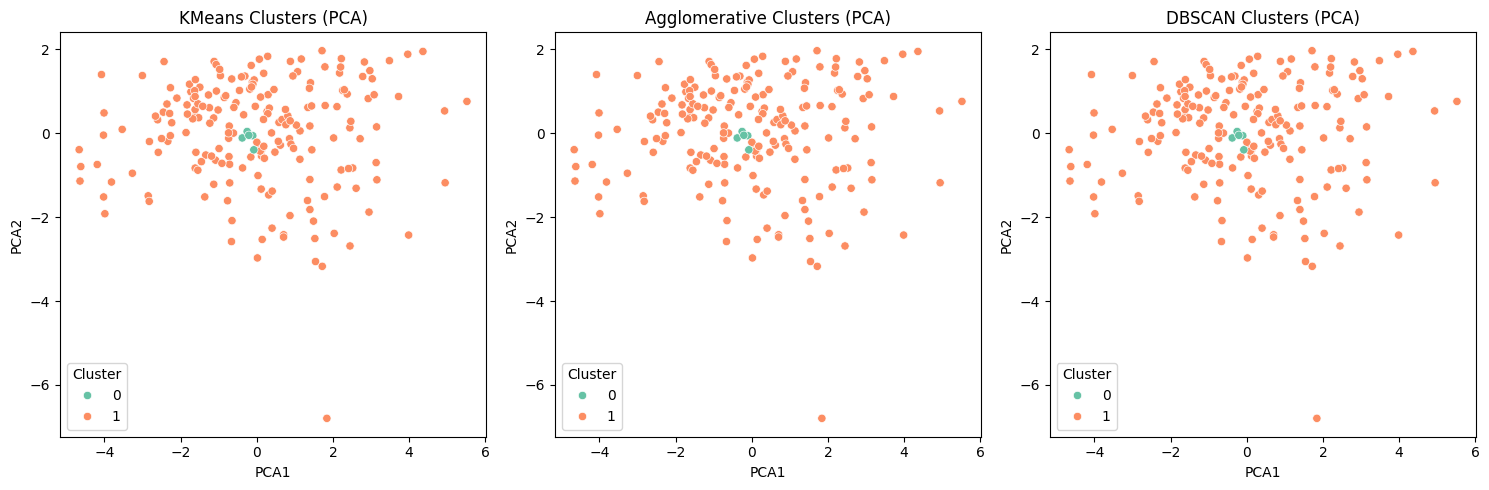

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the datasets
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

# --- Feature Engineering ---
# Aggregate transaction-level features
agg_transactions = transactions_df.groupby('CustomerID').agg({
    'TransactionID': 'count',  # Total number of transactions
    'TotalValue': 'sum',  # Total spending by customer
    'ProductID': 'nunique',  # Number of unique products purchased
    'Quantity': 'sum',  # Total quantity purchased
    'Price': 'mean',  # Average price paid for products
    'TransactionDate': ['min', 'max']  # First and last transaction date
}).reset_index()

# Flatten the MultiIndex columns created during aggregation
agg_transactions.columns = ['CustomerID', 'TotalTransactions', 'TotalSpending', 'UniqueProducts', 'TotalQuantity', 'AveragePrice', 'FirstPurchaseDate', 'LastPurchaseDate']

# Merge with customer profile data
customer_data = pd.merge(customers_df, agg_transactions, on='CustomerID', how='left')

# --- Calculate Recency Features ---
# Calculate recency based on today's date
customer_data['RecencySignup'] = (pd.to_datetime('today') - pd.to_datetime(customer_data['SignupDate'])).dt.days
customer_data['RecencyLastPurchase'] = (pd.to_datetime('today') - pd.to_datetime(customer_data['LastPurchaseDate'])).dt.days

# --- Create Derived Metrics ---
# Spending per transaction
customer_data['SpendingPerTransaction'] = customer_data['TotalSpending'] / customer_data['TotalTransactions']
# Frequency of purchases (transactions per day since signup)
customer_data['Frequency'] = customer_data['TotalTransactions'] / customer_data['RecencySignup']

# --- Select Features for Clustering ---
features = [
    'TotalTransactions', 'TotalSpending', 'UniqueProducts', 'TotalQuantity',
    'RecencySignup', 'RecencyLastPurchase', 'SpendingPerTransaction', 'Frequency'
]

# Prepare feature matrix (X)
X = customer_data[features]

# --- Handle Missing Values ---
# Fill missing values with column mean (imputation)
X = X.fillna(X.mean())  # You can also use other imputation strategies like median or 0

# --- Standardize the Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Clustering Algorithms ---
# Define clustering algorithms
algorithms = {
    'KMeans': KMeans(n_clusters=4, random_state=42),
    'Agglomerative': AgglomerativeClustering(n_clusters=4),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5)
}

# --- Evaluate Clustering ---
results = {}

for name, algorithm in algorithms.items():
    # Apply the algorithm
    labels = algorithm.fit_predict(X_scaled)

    # Handle DBSCAN's behavior for noise (-1 label for outliers)
    if name == 'DBSCAN':
        # DBSCAN labels noise points as -1, so we reset them to the largest cluster number
        if len(set(labels)) > 1 and -1 in labels:
            labels = [label if label != -1 else max(labels) + 1 for label in labels]

    # Add clustering labels to the data
    customer_data[name + '_Cluster'] = labels

    # Calculate evaluation metrics
    silhouette_avg = silhouette_score(X_scaled, labels)
    db_index = davies_bouldin_score(X_scaled, labels)

    # Store results
    results[name] = {'labels': labels, 'silhouette': silhouette_avg, 'db_index': db_index}

# --- Visualize Results for Each Clustering Algorithm ---
plt.figure(figsize=(15, 5))

for i, (name, metrics) in enumerate(results.items(), 1):
    plt.subplot(1, 3, i)
    customer_data['Cluster'] = metrics['labels']
    sns.scatterplot(x='TotalTransactions', y='TotalSpending', hue='Cluster', data=customer_data, palette='Set2')
    plt.title(f'{name} Clustering')

plt.tight_layout()
plt.show()

# --- Print Results (Metrics) ---
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  Silhouette Score: {metrics['silhouette']:.3f}")
    print(f"  Davies-Bouldin Index: {metrics['db_index']:.3f}")
    print("-" * 20)

# --- Dimensionality Reduction for Visualization (PCA) ---
# Apply PCA to reduce dimensions for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Visualize clusters using PCA (for each algorithm)
plt.figure(figsize=(15, 5))

for i, (name, metrics) in enumerate(results.items(), 1):
    customer_data['PCA1'] = pca_result[:, 0]
    customer_data['PCA2'] = pca_result[:, 1]
    plt.subplot(1, 3, i)
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_data, palette='Set2')
    plt.title(f'{name} Clusters (PCA)')

plt.tight_layout()
plt.show()


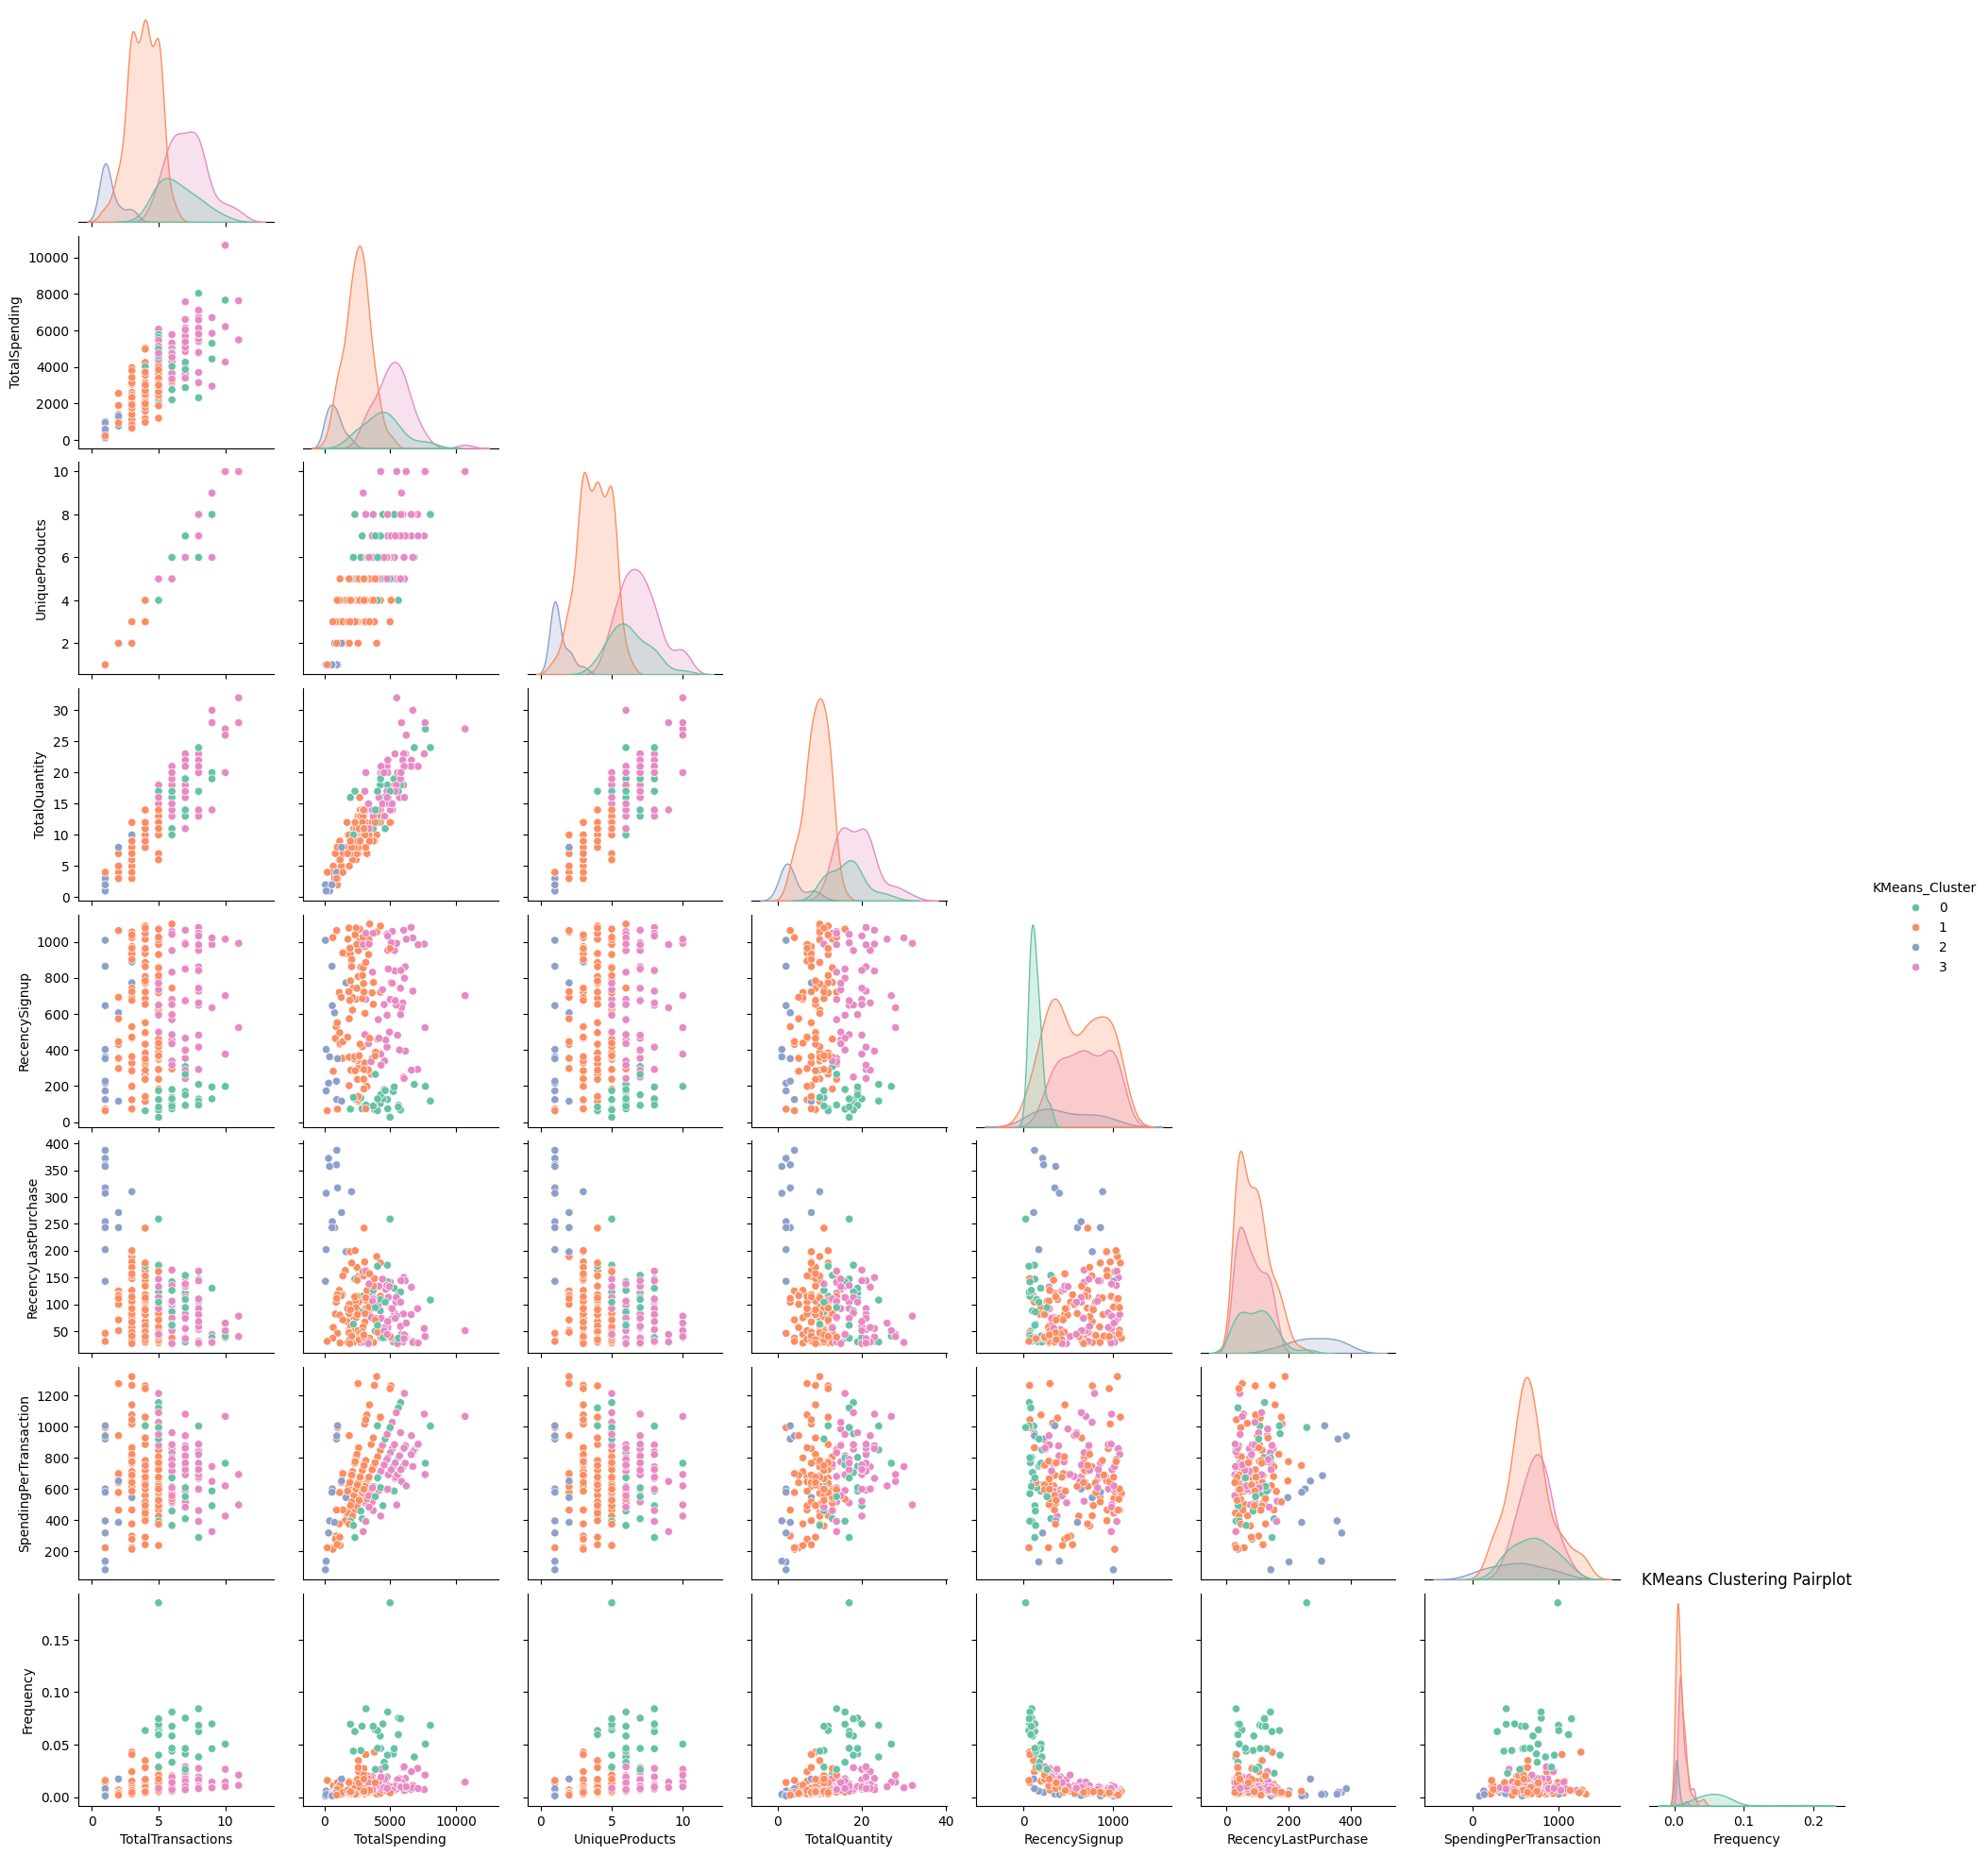

In [3]:
# Pairplot for KMeans clusters
sns.pairplot(customer_data, vars=features, hue='KMeans_Cluster', palette='Set2', diag_kind='kde', corner=True)
plt.title("KMeans Clustering Pairplot")
plt.show()


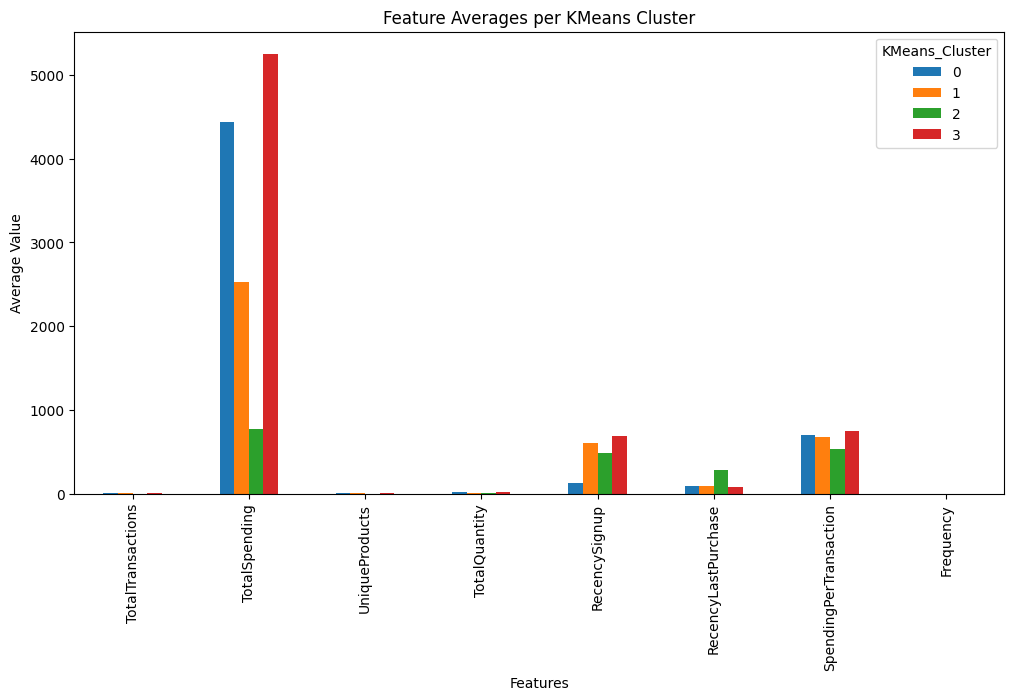

In [4]:
# Calculate cluster-wise averages for KMeans
cluster_averages = customer_data.groupby('KMeans_Cluster')[features].mean()

# Plot feature averages per cluster
cluster_averages.T.plot(kind='bar', figsize=(12, 6), title='Feature Averages per KMeans Cluster', legend=True)
plt.ylabel('Average Value')
plt.xlabel('Features')
plt.show()



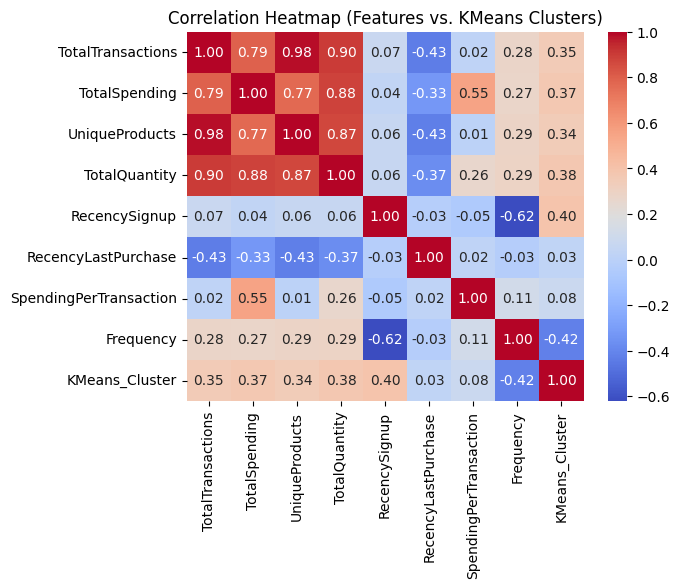

In [5]:
# Compute correlation between features and KMeans clusters
correlation_matrix = customer_data[features + ['KMeans_Cluster']].corr()

# Heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap (Features vs. KMeans Clusters)")
plt.show()


<ipython-input-6-383cc7394ba3>:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(k_values, inertia, 'o-', marker='s')


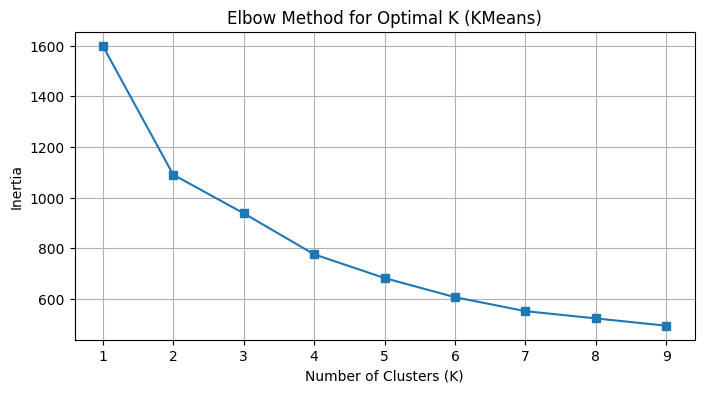

In [6]:
# Elbow method for optimal number of clusters
inertia = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(k_values, inertia, 'o-', marker='s')
plt.title("Elbow Method for Optimal K (KMeans)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


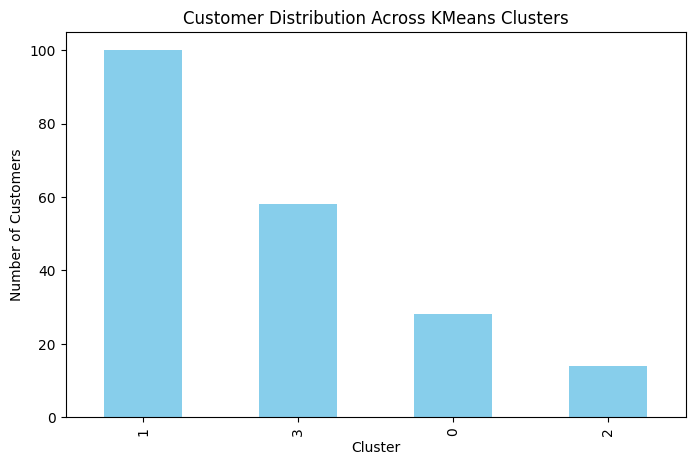

In [7]:
# Distribution of customers across clusters (KMeans example)
customer_data['KMeans_Cluster'].value_counts().plot(kind='bar', figsize=(8, 5), color='skyblue')
plt.title("Customer Distribution Across KMeans Clusters")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()
